In [62]:
import os
import pickle
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
from PcmPy.tmp__inference_cka import fit_CKA_individ, fit_CKA_group_crossval
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# make monkey dataframe

In [38]:
conditionID = [100, 101, 110, 111, 200, 201, 210, 211]
conditionName = ['RforBot','RforTop','RrevBot', 'RrevTop', 'LforBot','LforTop','LrevBot', 'LrevTop']

# load monkey data:
monk1 = pd.read_csv(os.path.join(analysisDir, 'monk1.csv'))
Y1 = monk1.values
monk2 = pd.read_csv(os.path.join(analysisDir, 'monk2.csv'))
Y2 = monk2.values

Y = {'monk1': Y1, 'monk2': Y2}
neurons_monk = {'monk1_left': np.arange(0,263), 'monk1_right': np.arange(263,263+270), 'monk2_left': np.arange(0,330), 'monk2_right': np.arange(330,330+279)}

df = {'monk': [], 'hem': [], 'cond': [], 'lateral':[], 'hand': [], 'direction': [], 'startPos': [], 'FR': [], 'meanFR': []}

for m in ['monk1', 'monk2']:
    Y_monk = Y[m]
    for h, hem in enumerate(['left', 'right']):
        if hem == 'left':
            neurons = neurons_monk[f'{m}_left']
        else:
            neurons = neurons_monk[f'{m}_right']
        Y_hem = Y_monk[:, neurons]
        for c, cond in enumerate(conditionName):
            hand = 'R' if cond[0] == 'R' else 'L'
            direction = 'forward' if 'for' in cond else 'reverse'
            startPos = 'Top' if 'Top' in cond else 'Bottom'
            contra = 'contra' if ( (hem == 'left' and hand == 'R') or (hem == 'right' and hand == 'L') ) else 'ipsi'

            # change cond name to contra/ipsi:
            if contra == 'contra':
                # replace first letter with C
                cond = list(cond)
                cond[0] = 'C'
                cond = ''.join(cond)
            else:
                cond = list(cond)
                cond[0] = 'I'
                cond = ''.join(cond)
            
            FR_values = Y_hem[c, :]
            df['monk'].append(m)
            df['hem'].append('rhem' if hem == 'right' else 'lhem')
            df['cond'].append(cond)
            df['lateral'].append(contra)
            df['hand'].append(hand)
            df['direction'].append(direction)
            df['startPos'].append(startPos)
            df['FR'].append(FR_values)
            df['meanFR'].append(np.mean(FR_values))
df = pd.DataFrame(df)
df



,monk,hem,cond,lateral,hand,direction,startPos,FR,meanFR
0,monk1,lhem,CforBot,contra,R,forward,Bottom,"[3.83276636944416, 0.112887285661144, 1.413886...",11.787539
1,monk1,lhem,CforTop,contra,R,forward,Top,"[6.28651796778347, 0.522335139547832, 1.143359...",11.809296
2,monk1,lhem,CrevBot,contra,R,reverse,Bottom,"[5.86507088984944, 0.40459687094298, 1.8396468...",11.894393
3,monk1,lhem,CrevTop,contra,R,reverse,Top,"[3.52827797568959, 0.233644892035512, 2.966497...",12.073037
4,monk1,lhem,IforBot,ipsi,L,forward,Bottom,"[3.39814609189972, 0.435130134967314, 1.371552...",12.371489
5,monk1,lhem,IforTop,ipsi,L,forward,Top,"[15.3720502330605, 1.80067610256175, 1.2410482...",12.630927
6,monk1,lhem,IrevBot,ipsi,L,reverse,Bottom,"[1.47560061614555, 2.04126569256569, 0.8360168...",12.375595
7,monk1,lhem,IrevTop,ipsi,L,reverse,Top,"[1.07624791289179, 1.73608027419975, 0.4665667...",12.626057
8,monk1,rhem,IforBot,ipsi,R,forward,Bottom,"[9.89022325129932, 10.5309873263686, 2.6471805...",12.928321
9,monk1,rhem,IforTop,ipsi,R,forward,Top,"[11.6732598108401, 11.1890220153733, 2.2991865...",13.103591


# Mean activity contra vs ipsi

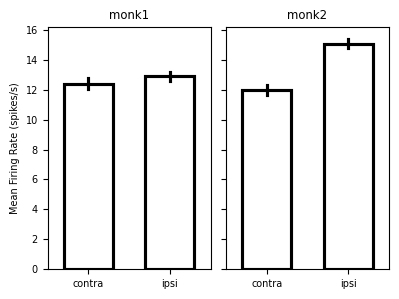

In [60]:
fig, ax = plt.subplots(1,2, figsize=(4,3), sharey=True)
for i, monk in enumerate(['monk1','monk2']) :
    df_tmp = df[df['monk']==monk].copy()
    
    sns.barplot(data=df_tmp, x='lateral', y='meanFR', ax=ax[i], width=0.6, fill=False, color='black')
    ax[i].set_title(f'{monk}')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Mean Firing Rate (spikes/s)')
plt.tight_layout()
plt.show()



# Covariance matrix

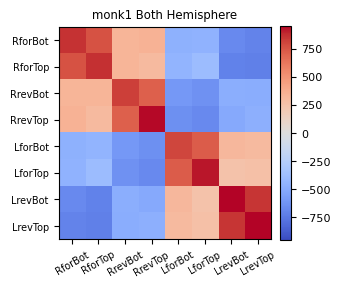

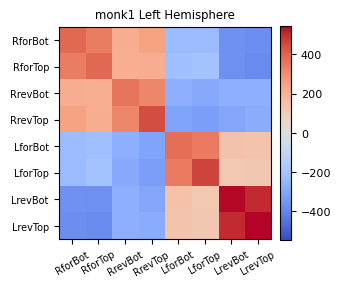

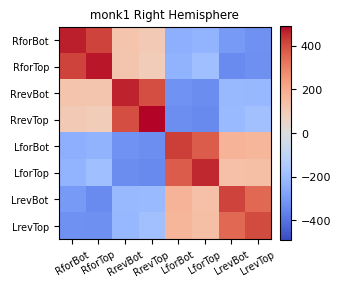

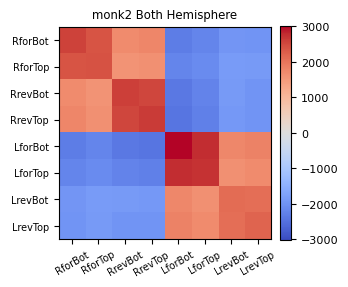

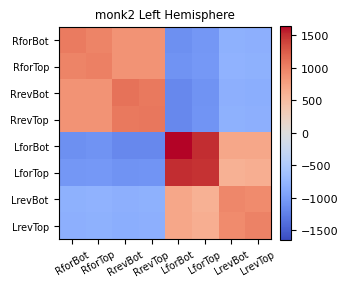

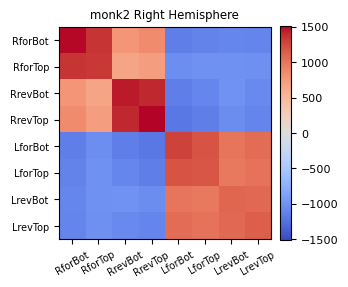

In [ ]:
conditionID = [100, 101, 110, 111, 200, 201, 210, 211]
conditionName = ['RforBot','RforTop','RrevBot', 'RrevTop', 'LforBot','LforTop','LrevBot', 'LrevTop']

# load monkey data:
monk1 = pd.read_csv(os.path.join(analysisDir, 'monk1.csv'))
Y1 = monk1.values
monk2 = pd.read_csv(os.path.join(analysisDir, 'monk2.csv'))
Y2 = monk2.values

Y = {'monk1': Y1, 'monk2': Y2}
neurons_monk = {'monk1_left': np.arange(0,263), 'monk1_right': np.arange(263,263+270), 'monk2_left': np.arange(0,330), 'monk2_right': np.arange(330,330+279)}

for monk in ['monk1','monk2']:
    # load monkey data:
    Y_monk = Y[monk]
    left_neurons = neurons_monk[f'{monk}_left']
    right_neurons = neurons_monk[f'{monk}_right']
    conditionID = [100, 101, 110, 111, 200, 201, 210, 211]
    conditionName = ['RforBot','RforTop','RrevBot', 'RrevTop', 'LforBot','LforTop','LrevBot', 'LrevTop']

    labels = conditionName
    cond_vec = np.array(conditionID)
    part_vec = np.ones_like(cond_vec)
    
    Y_monk = Y_monk - np.mean(Y_monk, axis=0, keepdims=True)
    G_hat = Y_monk @ Y_monk.T / Y_monk.shape[0]

    plt.rcParams.update({'font.size': 7})
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    cmap = 'coolwarm'
    vmin = -np.max(np.abs(G_hat))
    vmax = np.max(np.abs(G_hat))
    ax.imshow(G_hat,vmin=vmin,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=30)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_title(f'{monk} Both Hemisphere')

    # left hem:
    Y_left = Y_monk[:, left_neurons]
    G_hat_left = Y_left @ Y_left.T / Y_left.shape[0]
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    cmap = 'coolwarm'
    vmin = -np.max(np.abs(G_hat_left))
    vmax = np.max(np.abs(G_hat_left))
    ax.imshow(G_hat_left,vmin=vmin,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=30)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_title(f'{monk} Left Hemisphere')

    # right hem:
    Y_right = Y_monk[:, right_neurons]
    G_hat_right = Y_right @ Y_right.T / Y_right.shape[0]
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    cmap = 'coolwarm'
    vmin = -np.max(np.abs(G_hat_right))
    vmax = np.max(np.abs(G_hat_right))
    ax.imshow(G_hat_right,vmin=vmin,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=30)
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_title(f'{monk} Right Hemisphere')



